# Regression Models

The following is a in depth demonstration of the regression models in Darts - from basic to advanced features, including:

- Darts' regression models
- lags and lagged data extraction
- covariates usage
- parameters output_chunk_length in relation with multi_models
- one-shot and auto-regressive predictions
- multi output support
- probablistic forecasting
- explainability
- and more

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

# activate javascript
from shap import initjs

initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge

from darts.models import (
    LinearRegressionModel,
    RegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
)
from darts.metrics import mape
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.explainability import ShapExplainer

### Input Dataset
For this notebook, we use the Electricity Consumption Dataset from households in Zurich, Switzerland.

The dataset has a quarter-hourly frequency (15 Min time intervals), but we resample it to hourly 
frequency to keep things simple.

**Target series** (the series we want to forecast):
- **Value_NE5**: Electricity consumption by households on grid level 5 (in kWh).

**Covariates** (external data to help improve forecasts):
The dataset also comes with weather measurements that we can use as covariates. For simplicity, we use:
- **T [°C]**: Measured temperature
- **StrGlo [W/m2]**: Measured solar irradation
- **RainDur [min]**: Measured raining duration

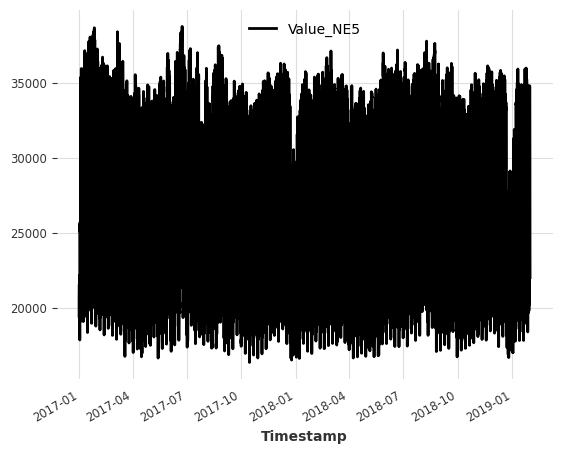

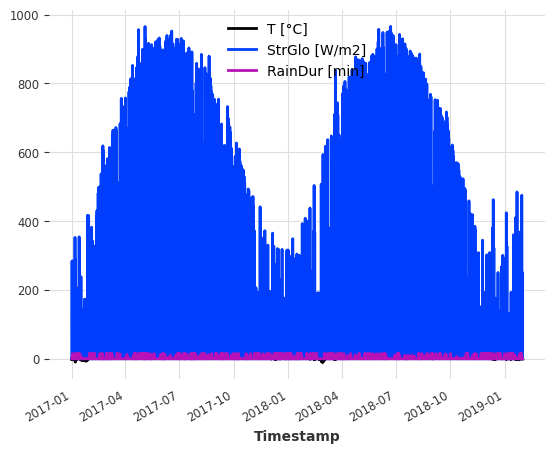

In [3]:
ts_energy = ElectricityConsumptionZurichDataset().load()

# extract values recorded between 2017 and 2019
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2019-01-31")
ts_energy = ts_energy[start_date:end_date]

# resample to hourly frequency
ts_energy = ts_energy.resample(freq="H")

# extract temperature, solar irradiation and rain duration
ts_weather = ts_energy[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]

# extract households energy consumption
ts_energy = ts_energy["Value_NE5"]

# create train and validation splits
validation_cutoff = pd.Timestamp("2018-10-31")
ts_energy_train, ts_energy_val = ts_energy.split_after(validation_cutoff)

ts_energy.plot()
plt.show()

ts_weather.plot()
plt.show()

## Darts Regression Models

Regression is a statistical method used in data science and machine learning to model the relationship between a dependent variable (target `y`) and one or more independent variables (features `X`).

For convenience, the core Darts package ships with a couple of regression models:
- `LinearRegressionModel` and `RandomForest`: fully integrated sklearn models
- `RegressionModel`: wrap the Darts Model API around any sklearn-like model
- `XGBModel`: wrapper around [XGBoost's](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) `XGBRegressor`

In addition to these, we also offer a unified API for some state of the art regression models that can be installed following our [installation guide](https://github.com/unit8co/darts/blob/master/INSTALL.md):

* `LightGBMModel`: wrapper around [LightGBM's](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm-lgbmregressor) `LightGBMRegressor`
* `CatBoostModel`: wrapper around [CatBoost's](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) `CatBoostRegressor`.

In Darts, the forecasting problem is translated into a regression problem by converting the time series into two tabular arrays:
- `X`: features or input array with the shape (number of samples/observations, number of features)
  - The number of features is given by the total number of (feature specific) target, past, and future covariates lags.
- `y`: target or label array with the shape (number of samples/observations, number of targets)
  - The number of targets is given by the model parameters `output_chunk_length` and `multi_models` (we'll explain this later on).

### Target and covariates lags

A lagged feature is the value of a feature at a previous or future time step compared to some reference point. 

In Darts, the value of the lag specifies the position of the feature value relative to the first predicted target time step `y_t0` for each observation/sample (a row in `X`).

- `lag == 0`: position of the first predicted time step `t0`, e.g. position of `y_t0`
- `lag < 0`: all positions in the past of the first predicted time step `t-1`, `t-2`, ...
- `lag > 0`: all positions in the future of the first predicted time step `t+1`, `t+2`, ...

The choice of lags is critical in achieving good predictive accuracy. We want the model to receive relevant information to capture the temporal properties/dependencies our target series (patterns, seasonalities, trends, ...). It also has a considerable impact on the model performance/complexity, as each additional lag adds a new feature to `X`.

At model creation, we can set lags for the target and the covariates series separately.

- `lags`: lags for the target series (the one we want to forecast)
- `lags_past_covariates`: optionally, lags for a past covariates series (external past-observed features to help improve forecasts)
- `lags_future_covariates`: optionally, lags for a future covariates series (external future-known features to help improve forecasts)

There are multiple ways to define your lags `(int, List[int], Tuple[int, int], ...)`. You can find out more about this in the [RegressionModel docs](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html#darts.models.forecasting.regression_model.RegressionModel).

### Lagged data extraction
Now, let's have a look at how `X` and `y` is extracted for training using the scenario from below:

- `lags=[-4,-3,-2,-1]`: use the last 4 target values (green) before the first predicted time step (orange) as `X` features.
- `output_chunk_length=1`: predict the target value `y` of next (`1`) time step (orange).
- we have a target series with 7 time steps `t_i, ..., t_i+6` (blue).

*Note: This example only shows target `lags` extraction, but the same is applied to `lags_past/future_covariates`.*

![forecast_single_model_ocl3](./static/images/regression_model_train.png)

## Examples
Let's try to apply this to our electricity dataset. Assume, we want to predict the consumption of the next couple of hours after the end of our training set. 

As input features we give it the consumption at the same hour from one and two days ago -> `lags=[-24, -48]`.

<Axes: xlabel='Timestamp'>

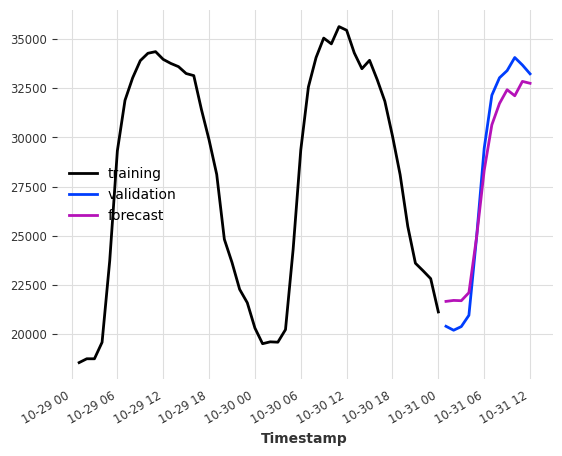

In [4]:
model = LinearRegressionModel(lags=[-24, -48])
model.fit(ts_energy_train)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Covariates-based forecasting

To use external data next to the history of our target series, we specify past and/or future covariates lags and then pass `past_covariates` and/or `future_covariates` to `fit()` and `predict()`.

Let's assume that instead of having weather measurements, we actually have weather forecasts. Then we could use them as future_covariates. **We only do this here for demonstration purposes!**

Below is an example that uses the last 24 hours (`24`) from hour target series (electricity consumption) and the values at the predicted time step (`[0]`) of our weather "forecasts".

<Axes: xlabel='Timestamp'>

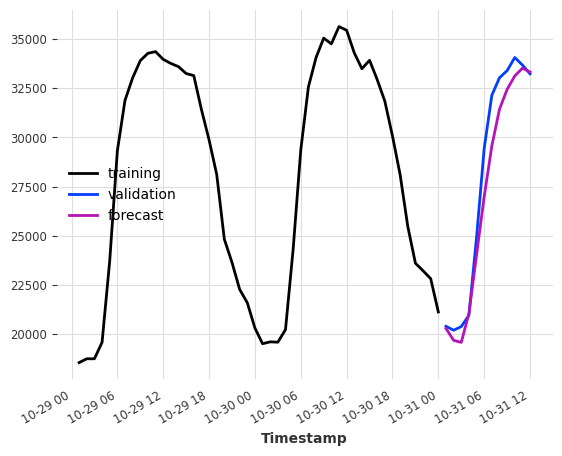

In [5]:
model = LinearRegressionModel(lags=24, lags_future_covariates=[0])
model.fit(ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

### Using only covariates

Sometimes, we might also be interested in a forecasting model that purely relies on the covariates values.

To do this, specify at least one of `lags_past_covariates` or `lags_future_covariates` and set `lags=None`. 
Darts regression models are trained in a supervised manner, so we still have to provide the target series for training.

How well can we predict the electricity consumption using only the weather "forecasts" as input?

The lags tuple `(24, 1)` means (number of lags in the past, number of lags in the future).

<Axes: xlabel='Timestamp'>

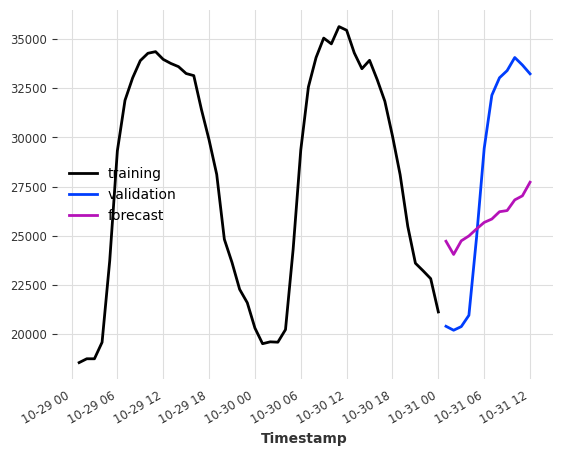

In [6]:
model = LinearRegressionModel(lags=None, lags_future_covariates=(24, 1))
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")

And what if we added some calendar information? We can let the model generate calendar attribute encodings for free with `add_encoders`.

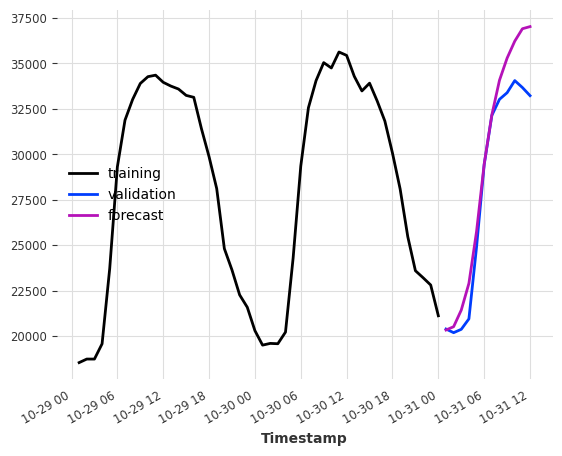

In [7]:
model = LinearRegressionModel(
    lags=None,
    lags_future_covariates=(24, 1),
    add_encoders={
        "cyclic": {"future": ["minute", "hour", "dayofweek", "month"]},
        "tz": "CET",
    },
)
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:12].plot(label="validation")
pred.plot(label="forecast")
plt.show()

### Component-specific lags

If the target or any of the covariates is multivariate (has multiple components/columns), we can use dedicated lags for each component.
Just pass a dictionary to the `lags*` parameters with the component name as key and the lags as value.

In the example below, we set the default lags to `(24,1)` (used for the covariates components `'T [°C]'` and `'StrGlo [W/ms]'`) and give feature `'RainDur [min]'` a dedicated lag `[0]`.

<Axes: xlabel='Timestamp'>

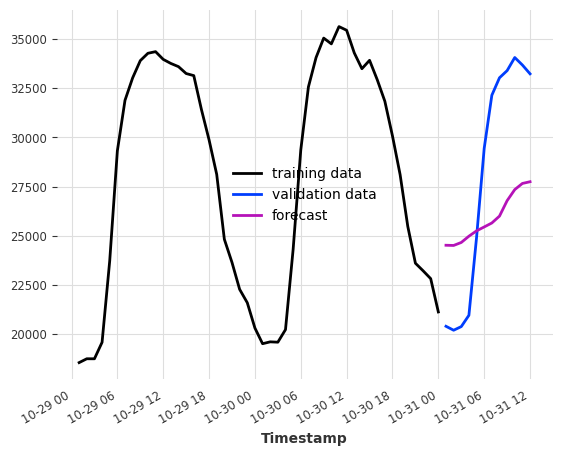

In [8]:
model = LinearRegressionModel(
    lags=None, lags_future_covariates={"default_lags": (24, 1), "RainDur [min]": [0]}
)
model.fit(series=ts_energy_train, future_covariates=ts_weather)
pred = model.predict(12)

ts_energy_train[-48:].plot(label="training data")
ts_energy_val[:12].plot(label="validation data")
pred.plot(label="forecast")

### Model's output chunk length

This key parameter sets the *number of time steps that can be predicted at once by the internal regression model*.

It is not the same as forecast horizon `n` from `predict()` which is the **desired** the number of generated prediction points, that is achieved either with:
- a single shot forecast (if `n <= output_chunk_length`), or
- an auto-regressive forecast, consuming its own forecast (and future values of covariates) as input for additional predictions (otherwise)

For example, if we want our model to forecast the next 24 hours of electricity consumption based on the last day of consumption, setting `output_chunk_length=24` ensures that the model will not consume its forecasts or future values of our covariates to predict the entire day.

<Axes: xlabel='Timestamp'>

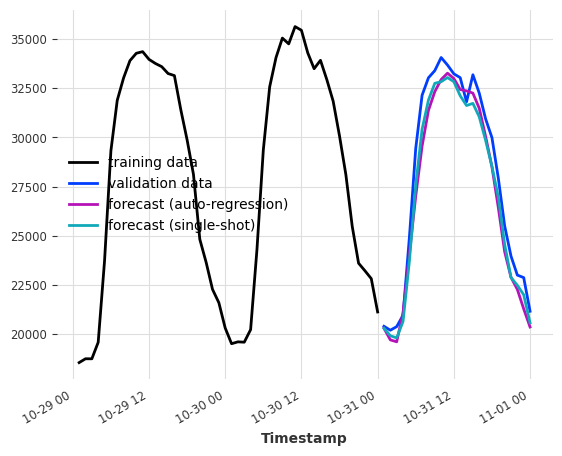

In [9]:
model_auto_regression = LinearRegressionModel(lags=24, output_chunk_length=1)
model_single_shot = LinearRegressionModel(lags=24, output_chunk_length=24)

model_auto_regression.fit(ts_energy_train)
model_single_shot.fit(ts_energy_train)

pred_auto_regression = model_auto_regression.predict(24)
pred_single_shot = model_single_shot.predict(24)

ts_energy_train[-48:].plot(label="training data")
ts_energy_val[:24].plot(label="validation data")
pred_auto_regression.plot(label="forecast (auto-regression)")
pred_single_shot.plot(label="forecast (single-shot)")

### Multi-model forecasting
When `output_chunk_length>1`, the model behavior can be further parametrized by modifying the `multi_models` argument.

`multi_models=True` is the default behavior in Darts and was shown above. We create `output_chunk_length` copies of the model, and train each of them to predict one of the `output_chunk_length` time steps (using the same inputs). 
This approach is more computationally and memory intensive but tends to yield better results.

### Single-model forecasting
When `multi_model=False`, we use a single model and train it to predict only the last point in `output_chunk_length`. This reduces model complexity as only a single set of coefficients will be trained and stored.

We are still able to predict all points from 1 until `output_chunk_length` by shifting the lags during tabularization.
This means that a new set of input values is used for each forecasted value. Due to the shifting, the minimum length requirement for the training series will also be increased.

<Axes: xlabel='Timestamp'>

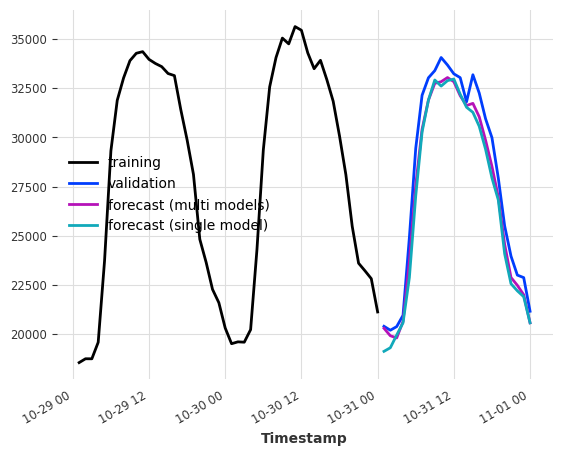

In [10]:
multi_models = LinearRegressionModel(lags=24, output_chunk_length=24, multi_models=True)
single_model = LinearRegressionModel(
    lags=24, output_chunk_length=24, multi_models=False
)

multi_models.fit(ts_energy_train)
single_model.fit(ts_energy_train)

pred_multi_models = multi_models.predict(24)
pred_single_model = single_model.predict(24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_multi_models.plot(label="forecast (multi models)")
pred_single_model.plot(label="forecast (single model)")

### Visualization
To vizualize what is happening under the hood, let's simplify the model a bit and show the process for different parameters.

#### Multi models with auto-regression
Model setup: `LinearRegressionModel(lags=[-4, -3, -2, -1], output_chunk_length=2, multi_models=True)`.

When calling `predict(n=4)`, the input series is processed as follows:

![forecast_multi_model_ocl2](./static/images/multi_model_ocl2.png)

Since `n>output_chunk_length`, the model had to use auto-regression and the forecasted period is composed of two chunks of size `output_chunk_length`.
There was no lags shift per output chunk because `multi_models=True`.

#### Single model with auto-regression

Model setup: `LinearRegressionModel(lags=[-4, -3, -2, -1], output_chunk_length=2, multi_models=False)`.

![forecast_single_model_ocl2](./static/images/single_model_ocl2.png)

Apart from the auto-regressive prediction, we can see the lags shift per predicted time step because `multi_models=False`.

The same process also occurs during tabularizion for training the model: each green chunk is paired with an orange value, constituting the training dataset.

### Probabilistic forecasting

To make a model probablistic, set parameter `likelihood` to `quantile` or `poisson` when creating a `RegressionModel`. At prediction time, probabilistic models can either :
- use Monte Carlo sampling to generate samples based on the fitted distribution parameters when `num_samples > 1`
- return the fitted distribution parameters when `predict_likelihood_parameters=True`

Note that when using the `quantile` regressor, each quantile will be fitted by a different model.

Probabilistic models will generate different forecasts each time `predict()` is called with `num_samples > 1`. To get reproducible results, set the random seed when creating the model and call the methods in the exact same order.

Value_NE5_q0.05 : 19580.123046875
Value_NE5_q0.50 : 19623.302734375
Value_NE5_q0.95 : 20418.7421875


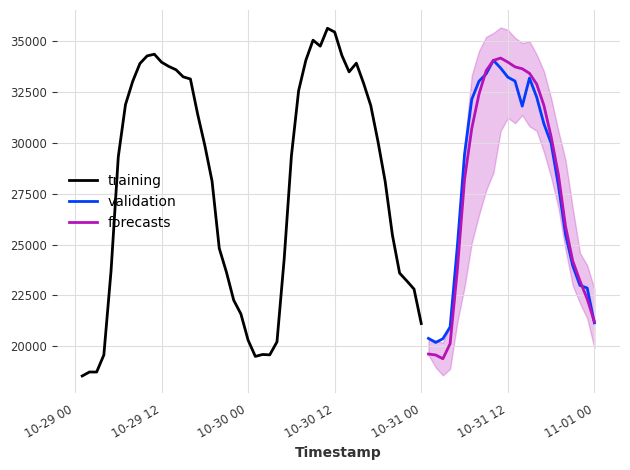

In [11]:
model = XGBModel(
    lags=24, output_chunk_length=1, likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
)

model.fit(ts_energy_train)

pred_samples = model.predict(n=24, num_samples=200)
pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

for val, comp in zip(pred_params.values()[0], pred_params.components):
    print(f"{comp} : {round(val, 3)}")

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_samples.plot(label="forecasts")
plt.tight_layout()

### MultiOutputRegressor wrapper

Some regression models support native multi-output support. This is required to fit and predict:
- multiple outputs/multiple target steps (with `output_chunk_length>1` and `multi_models=True`)
- probabilistic models using quantile regression
- multivariates series

For models that don't support it, Darts wraps sklearn's `MultiOutputRegressor` around them to handle the logic under the hood.

## Explainability

We offer explainability for the regression models with Darts' `ShapExplainer`. The explainer uses [shap](https://github.com/shap/shap), a library based on game theory, to give insights into feature importances over time for our forecast horizon.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


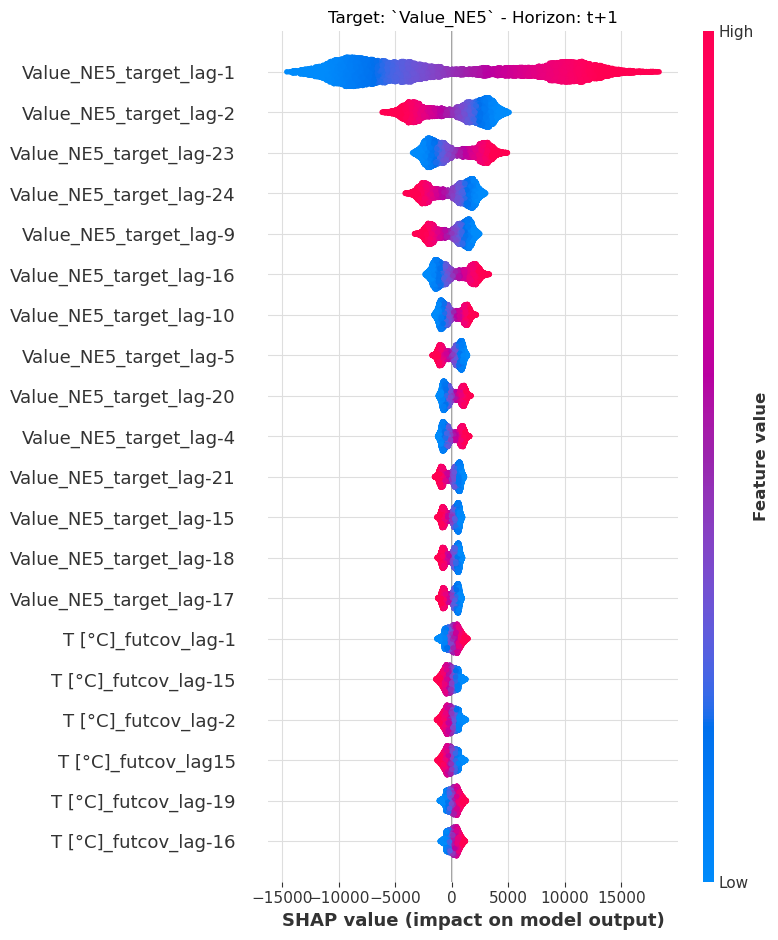

In [12]:
model = LinearRegressionModel(lags=24, lags_future_covariates=(24, 24))
model.fit(ts_energy_train, future_covariates=ts_weather)
shap_explainer = ShapExplainer(model=model)
shap_values = shap_explainer.summary_plot()

In [13]:
# extracting the end of each series to reduce computation time
foreground_target = ts_energy_train[-24 * 2 :]
foreground_future_cov = ts_weather[foreground_target.start_time() :]

shap_explainer.force_plot_from_ts(
    foreground_series=foreground_target,
    foreground_future_covariates=foreground_future_cov,
)

# the plot cannot be rendered on GitHub or the Documentation page. Run it locally to see it.

## Conclusion

By tabularizing the data and unifying the API across libraries, Darts closes the gap between traditional regression problems and timeseries forecasting.

`RegressionModel` and its sub-classes offer a wide range of functionalities which can be used to build strong models in just a few lines of codes.

# Appendix

### RegressionModel
`RegressionModel` wraps the Darts API around any sklearn regression model. With this we can use the model in the same way as any other Darts forecasting models.

As an examnple, fitting a Bayesian ridge regression on the example dataset takes only a few lines:

<Axes: xlabel='Timestamp'>

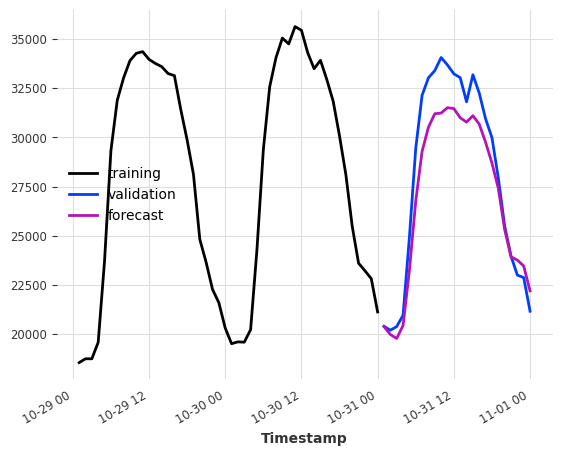

In [14]:
model = RegressionModel(
    lags=24,
    lags_future_covariates=(48, 24),
    model=BayesianRidge(),
    output_chunk_length=24,
)

model.fit(ts_energy_train, future_covariates=ts_weather)

pred = model.predict(n=24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred.plot(label="forecast")

The underlying model methods remain accessible and by combining the `BasesianRidge.coef_` attribute with the `RegressionModel.lagged_feature_names` attribute, the coefficients of the regression model can easily be interpreted:

In [15]:
# extract the coefficients of the first timestemp estimator
coef_values = model.model.estimators_[0].coef_
# get the lagged features name
coef_names = model.lagged_feature_names
# combine them in a dict
coefficients = {name: val for name, val in zip(coef_names, coef_values)}
# see the coefficient of the target value at last timestep before the forecasted period
{c_name: c_val for idx, (c_name, c_val) in enumerate(coefficients.items()) if idx < 5}

{'Value_NE5_target_lag-24': -0.3195560563281926,
 'Value_NE5_target_lag-23': 0.37621876784175745,
 'Value_NE5_target_lag-22': 0.005325414282057739,
 'Value_NE5_target_lag-21': -0.11885377506043901,
 'Value_NE5_target_lag-20': 0.12892167797527437}

One of the limitation of the `RegressionModel` class is that it does not provide probabilistic forecasting out of the box but it is possible to implement it by creating a new class inheriting from both `RegressionModel` and `_LikelihoodMixin` and implementing the missing methods (the `LinearRegressionModel` class can be use as a template).

## Custom model

You can even implement your own model as long as it works with tabular data and provides the `fit()` and `predict()` methods:

<Axes: xlabel='Timestamp'>

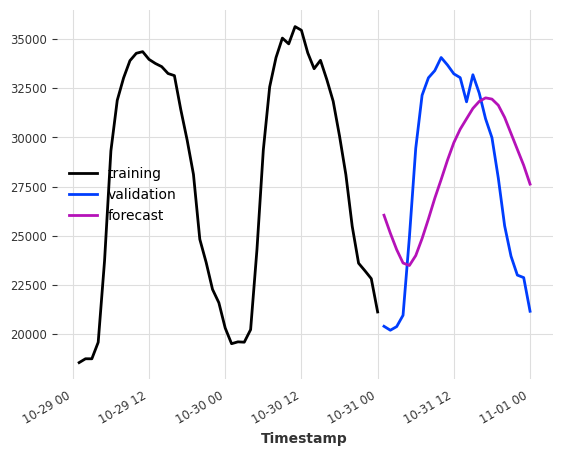

In [16]:
class CustomRegressionModel:
    def __init__(self, weights: np.ndarray):
        """Barebone weighted average"""
        self.weights = weights
        self.norm_coef = sum(weights)

    def fit(self, X: np.ndarray, y: np.ndarray):
        return self

    def predict(self, X: np.ndarray):
        """Apply weights on each sample"""
        return (
            np.stack([np.correlate(x, self.weights, mode="valid") for x in X])
            / self.norm_coef
        )

    def get_params(self, deep: bool):
        return {"weights": self.weights}


window_weights = np.arange(1, 25, 1) ** 2
model = RegressionModel(
    lags=24,
    output_chunk_length=24,
    model=CustomRegressionModel(window_weights),
    multi_models=False,
)
model.fit(ts_energy_train)
pred = model.predict(n=24)

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred.plot(label="forecast")

## Example of the boosted tree models

Make sure to have the dependencies for lightgbm and catboost installed. You can check out our installation guide [here](https://github.com/unit8co/darts/blob/master/INSTALL.md)

LightGBMModel MAPE: 2.2682070257112743
XGBoostModel MAPE: 3.5364068635935895
CatboostModel MAPE: 2.373275454432286


<Axes: xlabel='Timestamp'>

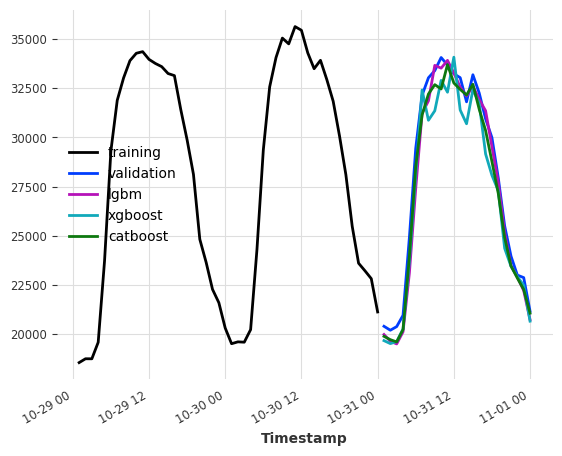

In [17]:
lgbm_model = LightGBMModel(lags=24, output_chunk_length=24, verbose=0)
xgboost_model = XGBModel(lags=24, output_chunk_length=24)
catboost_model = CatBoostModel(lags=24, output_chunk_length=24)

lgbm_model.fit(ts_energy_train)
xgboost_model.fit(ts_energy_train)
catboost_model.fit(ts_energy_train)

pred_lgbm = lgbm_model.predict(n=24)
pred_xgboost = xgboost_model.predict(n=24)
pred_catboost = catboost_model.predict(n=24)

print(f"LightGBMModel MAPE: {mape(ts_energy_val, pred_lgbm)}")
print(f"XGBoostModel MAPE: {mape(ts_energy_val, pred_xgboost)}")
print(f"CatboostModel MAPE: {mape(ts_energy_val, pred_catboost)}")

ts_energy_train[-48:].plot(label="training")
ts_energy_val[:24].plot(label="validation")
pred_lgbm.plot(label="lgbm")
pred_xgboost.plot(label="xgboost")
pred_catboost.plot(label="catboost")